## Homogeneous ice nucleation in an ab initio machine learning model of water
### Pablo M. Piaggi, Jack Weis, Athanassios Z. Panagiotopoulos, Pablo G. Debenedetti, and Roberto Car

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress
from scipy.interpolate import interp1d, CubicSpline, LSQUnivariateSpline, UnivariateSpline, splev, splrep

## Correlation times

In [2]:
def autocorr(x):
    result = np.correlate(x-np.mean(x), x-np.mean(x), mode='full')
    return result[int(result.shape[0]/2):]

In [3]:
def func(t,tau):
    return np.exp(-t/tau)

In [4]:
def func2(x,a,b):
    return np.exp(-b*(x-a))

In [5]:
font = {'family' : 'serif',
        'serif'   : 'palatino',
        #'sans-serif'    : 'Computer Modern Sans serif', 
        'style'   : 'normal',
        'variant'   : 'normal',
        'stretch'   : 'normal',
        'weight'   : 'normal',
        'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=True)
plt.rcParams['figure.figsize'] = (3*3.25, 3*2)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

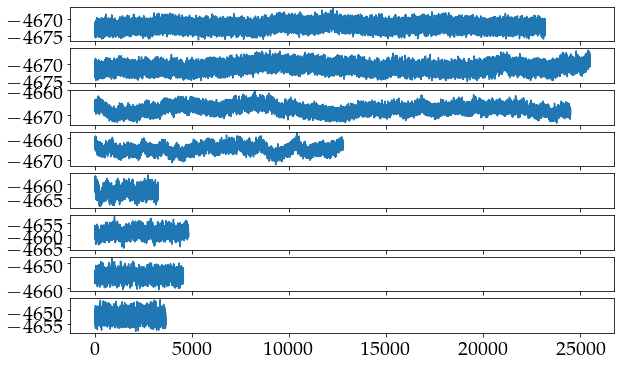

In [6]:
Nignore=0
temps=np.array([260,265,270,275,280,290,300,310])
fig, axs = plt.subplots(temps.shape[0],sharex=True)
for i in range(temps.shape[0]):
    filename=str(temps[i]) + "K/thermo.out"
    data=np.genfromtxt(filename)[Nignore:,:]
    x=np.linspace(0,data.shape[0]-1,data.shape[0])*500*0.0005
    axs[i].plot(x,data[:,2])
plt.show()

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


[2.59523628e+02 6.05772106e-02]


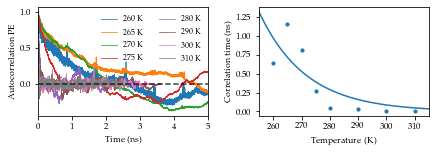

In [7]:
font = {'family' : 'serif',
        'serif'   : 'palatino',
        #'sans-serif'    : 'Computer Modern Sans serif', 
        'style'   : 'normal',
        'variant'   : 'normal',
        'stretch'   : 'normal',
        'weight'   : 'normal',
        'size'   : 9}
plt.rc('font', **font)
plt.rc('text', usetex=True)
plt.rcParams['figure.figsize'] = (7.0, 2)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, axs = plt.subplots(1,2)

RemoveInitial=np.array([20,20,10,10,2,2,2,2])
temps=np.array([260,265,270,275,280,290,300,310])
tau=np.zeros(temps.shape[0])

for i in range(temps.shape[0]):
    filename=str(temps[i]) + "K/thermo.out"
    data=np.genfromtxt(filename)
    Nignore=int(data.shape[0]/4) # Remove the initial quarter
    data=data[Nignore:,:]
    corr=autocorr(data[:,2])[RemoveInitial[i]:]
    x=np.linspace(0,corr.shape[0]-1,corr.shape[0])*500*0.0005/1000
    axs[0].plot(x,corr/np.amax(corr),label=str(temps[i]) + " K",linewidth=0.75)
    popt, pcov = curve_fit(func, x, corr/np.amax(corr))
    tau[i]=popt
axs[0].legend(frameon=False,ncol=2,fontsize=8)
axs[0].set_xlim([0,5])
axs[0].plot([0,5],[0,0],'--',color='black',alpha=0.75,zorder=6)
axs[0].set_xlabel("Time (ns)")
axs[0].set_ylabel("Autocorrelation PE")

axs[1].scatter(temps,tau,s=10)
popt, pcov = curve_fit(func2, temps,tau,  p0=(300,0.15))
print(popt)
x = np.linspace(255,315,1000)
axs[1].plot(x,func2(x,*popt))

axs[1].set_xlim([255,315])
axs[1].set_xlabel("Temperature (K)")
axs[1].set_ylabel("Correlation time (ns)")

plt.subplots_adjust(wspace=0.3)
#plt.savefig("correlation.png",dpi=300,bbox_inches='tight')  # publication quality

plt.show()

## Potential energy

In [8]:
def batch(data,total_batch_num,batch_num):
    """Make batches or blocks.

    Args:
        data (numpy array): Data
        total_batch_num (int): Total desired number of batches (blocks)
        batch_num (int): Number of the batch that will be returned

    Returns:
        numpy array: The selected batch of the data array
    """
    if (batch_num<0):
        raise Exception('batch_num must be greater than 0! Start from index 0')
    if (batch_num>(total_batch_num-1)):
        raise Exception('batch_num must be smaller than total_batch_num-1!')
    batch_size=int(data.shape[0]/total_batch_num)
    start=batch_size*batch_num
    end=batch_size*(batch_num+1)
    if (end>data.shape[0] or batch_num==(total_batch_num-1)):
        end=data.shape[0]
    return data[start:end]

def stdOfMeanWithWeights(values, weights):
    """Calculate a standard deviation of observations with weights.

    Args:
        values (numpy array): Data
        weights (numpy array): Weights

    Returns:
        float: Standard deviation
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average(np.power(values-average,2), weights=weights)
    N=np.power(np.sum(weights),2) / np.sum(np.power(weights,2)) #float(values.shape[0])
    return np.sqrt(variance/(N-1))

def averageBatch(values,weights,total_batch_num):
    """Find the weighted average of some quantity in batches

    Args:
        values (numpy array): Data to be averages
        weights (numpy array): Weights
        total_batch_num (int): Total desired number of batches (blocks)

    Returns:
        numpy array: The weighted average of the data in each batch (block)
        numpy array: The weights of each batch (block)

    """
    valuesVector=np.zeros([total_batch_num])
    Z=np.zeros([total_batch_num])
    for k in range(total_batch_num):
        valuesVector[k]=np.average(batch(values,total_batch_num,k),weights=batch(weights,total_batch_num,k))
        Z[k]=np.sum(batch(weights,total_batch_num,k))
    return valuesVector, Z

def errorOfMean(obs,numBatches):
    obsAvgBatches, Z = averageBatch(obs,np.ones(obs.shape),numBatches)
    obsAvg=np.average(obsAvgBatches, weights=Z)
    return stdOfMeanWithWeights(obsAvgBatches, Z)

In [11]:
enthalpy_liquid_temperatures=np.array([260,265,270,275,280,290,300,310])
enthalpy_liquid=np.zeros(enthalpy_liquid_temperatures.shape)
enthalpy_liquid_error=np.zeros(enthalpy_liquid_temperatures.shape)
numMolecules=288
numBatches=8
from_eV_to_kJmol=96.4853074993

for i in range(enthalpy_liquid_temperatures.shape[0]):
    enthalpy_liquid[i]=np.mean(np.genfromtxt(str(enthalpy_liquid_temperatures[i]) + "K/thermo.out")[:,2]*from_eV_to_kJmol/numMolecules)
    enthalpy_liquid_error[i]=errorOfMean(np.genfromtxt(str(enthalpy_liquid_temperatures[i]) + "K/thermo.out")[:,2]*from_eV_to_kJmol/numMolecules,numBatches)

enthalpy_liquid_error[1]=errorOfMean(np.genfromtxt("265K/thermo.out")[4000*5:,2]*from_eV_to_kJmol/numMolecules,numBatches)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


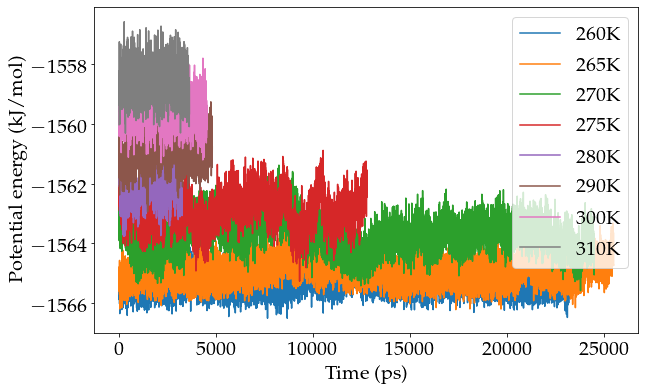

In [12]:
font = {'family' : 'serif',
        'serif'   : 'palatino',
        #'sans-serif'    : 'Computer Modern Sans serif', 
        'style'   : 'normal',
        'variant'   : 'normal',
        'stretch'   : 'normal',
        'weight'   : 'normal',
        'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=True)
plt.rcParams['figure.figsize'] = (3*3.25, 3*2)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
numMolecules=288
from_eV_to_kJmol=96.4853074993
for i in range(enthalpy_liquid_temperatures.shape[0]):
    plt.plot(np.genfromtxt(str(enthalpy_liquid_temperatures[i]) + "K/thermo.out")[::4,2]*from_eV_to_kJmol/numMolecules,label=str(enthalpy_liquid_temperatures[i]) + "K")

plt.legend()
plt.xlabel("Time (ps)")
plt.ylabel("Potential energy (kJ/mol)")
plt.show()

In [13]:
# This data is more reliable than the one reported in Piaggi et al. JCTC (2021)
np.savetxt('../SCAN-ML-Properties/enthalpy_liquid_temperatures.txt',enthalpy_liquid_temperatures)
np.savetxt('../SCAN-ML-Properties/enthalpy_liquid.txt',enthalpy_liquid)
np.savetxt('../SCAN-ML-Properties/enthalpy_liquid_error.txt',enthalpy_liquid_error)

In [14]:
# Using the ice data from Piaggi et al. JCTC (2021)
enthalpy_ice_temperatures=np.genfromtxt('../SCAN-ML-Properties/enthalpy_ice_temperatures.txt')
enthalpy_ice=np.genfromtxt('../SCAN-ML-Properties/enthalpy_ice.txt')
enthalpy_ice_error=np.genfromtxt('../SCAN-ML-Properties/enthalpy_ice_error.txt')

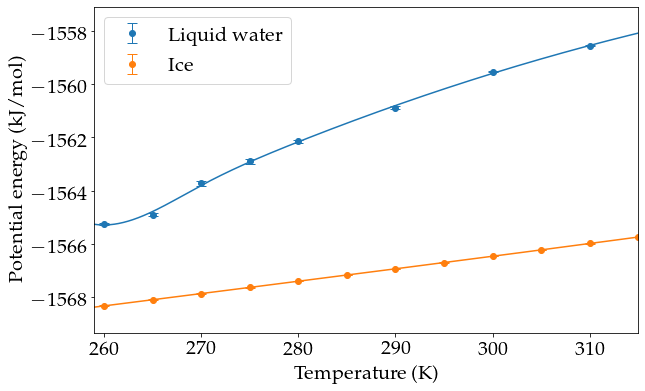

In [16]:
plt.errorbar(enthalpy_liquid_temperatures,enthalpy_liquid,enthalpy_liquid_error,fmt='o',elinewidth=1,capsize=5,label="Liquid water",color=colors[0])
f_water = splrep(enthalpy_liquid_temperatures,enthalpy_liquid,s=0.03,k=3)
x=np.linspace(250,320,1000)
plt.plot(x,splev(x,f_water),color=colors[0])

plt.errorbar(enthalpy_ice_temperatures,enthalpy_ice,enthalpy_ice_error,fmt='o',elinewidth=1,capsize=5,label="Ice",color=colors[1])
f_ice = splrep(enthalpy_ice_temperatures,enthalpy_ice,s=0.03,k=3)
plt.plot(x,splev(x,f_ice),color=colors[1])

plt.xlim([259,315])
#plt.ylim([-1566,-1557])
plt.legend()
plt.xlabel("Temperature (K)")
plt.ylabel("Potential energy (kJ/mol)")

plt.show()

## Chemical potential difference between ice and water

In [17]:
df_tip4pice=np.genfromtxt('../SCAN-ML-Properties/deltamu_tip4p.txt')
df_mW=np.genfromtxt('../SCAN-ML-Properties/deltamu_mW.txt')

In [18]:
cpwater_murphy_koop=np.genfromtxt("../ExperimentalProperties/cp_water_murphy_koop.txt")
cpice_giauque_stout_1936=np.genfromtxt("../ExperimentalProperties/cp_ice_giauque_stout_1936.txt")

In [19]:
# Splines
fwater = interp1d(cpwater_murphy_koop[:,0], cpwater_murphy_koop[:,1]/1000,kind='cubic',fill_value="extrapolate")
fice = interp1d(cpice_giauque_stout_1936[:,0], cpice_giauque_stout_1936[:,1]/1000,kind='cubic',fill_value="extrapolate")

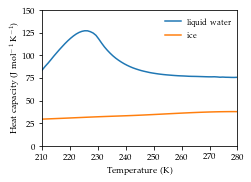

In [20]:
font = {'family' : 'serif',
        'serif'   : 'palatino',
        #'sans-serif'    : 'Computer Modern Sans serif', 
        'style'   : 'normal',
        'variant'   : 'normal',
        'stretch'   : 'normal',
        'weight'   : 'normal',
        'size'   : 9}
plt.rc('font', **font)
plt.rc('text', usetex=True)
plt.rcParams['figure.figsize'] = (3.5, 2.5)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

x=np.linspace(200,300,100)
plt.plot(x,1000*fwater(x),color=colors[0],label="liquid water")
plt.plot(x,1000*fice(x),color=colors[1],label="ice")
plt.xlim([210,280])
plt.ylim([0,150])

plt.legend(fontsize=8,frameon=False)

plt.xlabel("Temperature (K)")
plt.ylabel("Heat capacity (J mol$^{-1}$ K$^{-1}$)")

plt.show()

In [23]:
def cpexperimental(T):
    return fice(T)-fwater(T)  #kJ/ (mol K)

def deltaHexperimental(T):
    deltaH0=-6.01 #kJ/mol
    Tm=273.15
    temp=np.linspace(Tm,T,1000)
    cps=cpexperimental(temp)
    #print(T,deltaH0,np.trapz(cps,x=temp))
    return deltaH0+np.trapz(cps,x=temp)

def deltaGexperimental(T):
    Tm=273.15
    temp=np.linspace(Tm,T,1000)
    return -T*np.trapz(deltaHexperimental(temp)/np.power(temp,2),x=temp)

tempPrimesExperimental=np.linspace(200,280,100)
mydeltaGexperimental=np.zeros(tempPrimesExperimental.shape[0])
mydeltaHexperimental=np.zeros(tempPrimesExperimental.shape[0])
for i in range(tempPrimesExperimental.shape[0]):
    mydeltaGexperimental[i] = deltaGexperimental(tempPrimesExperimental[i])
    mydeltaHexperimental[i] = deltaHexperimental(tempPrimesExperimental[i])

In [24]:
np.savetxt('../ExperimentalProperties/deltamu.txt',mydeltaGexperimental)
np.savetxt('../ExperimentalProperties/deltamu_temperatures.txt',tempPrimesExperimental)

In [37]:
tempPrimes=np.linspace(260,320,67)
deltaH=splev(tempPrimes,f_ice)-splev(tempPrimes,f_water)

def deltaHfunc(T):
    f = interp1d(tempPrimes, deltaH,kind='cubic',fill_value="extrapolate")
    return f(T)

def deltaG(T,Tm):
    temp=np.linspace(Tm,T,1000)
    return -T*np.trapz(deltaHfunc(temp)/np.power(temp,2),x=temp)

simdeltaG=np.zeros(tempPrimes.shape[0])
for i in range(tempPrimes.shape[0]):
    simdeltaG[i] = deltaG(tempPrimes[i],Tm=312)

In [38]:
np.savetxt('../SCAN-ML-Properties/deltamu_scan_ml.txt',simdeltaG)
np.savetxt('../SCAN-ML-Properties/deltamu_scan_ml_temperatures.txt',tempPrimes)

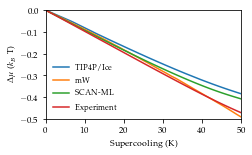

In [39]:
font = {'family' : 'serif',
        'serif'   : 'palatino',
        #'sans-serif'    : 'Computer Modern Sans serif', 
        'style'   : 'normal',
        'variant'   : 'normal',
        'stretch'   : 'normal',
        'weight'   : 'normal',
        'size'   : 9}
plt.rc('font', **font)
plt.rc('text', usetex=True)
plt.rcParams['figure.figsize'] = (3.5, 2.)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

mylinewidth=1.5
kb=0.008314462618
beta=1./(kb*(-df_tip4pice[:,0]+270))   
plt.plot(df_tip4pice[:,0],beta*df_tip4pice[:,1]*4.184,label="TIP4P/Ice",linewidth=mylinewidth)
beta=1./(kb*(-df_mW[:,0]+274.6))   
plt.plot(df_mW[:,0],beta*df_mW[:,1]*4.184,label="mW",linewidth=mylinewidth)
beta=1./(kb*tempPrimes) 
plt.plot(312-tempPrimes,beta*simdeltaG,linewidth=mylinewidth,label="SCAN-ML")
beta=1./(kb*tempPrimesExperimental)    
plt.plot(-tempPrimesExperimental+273.15,beta*mydeltaGexperimental,label="Experiment",linewidth=mylinewidth)

#plt.plot(312-tempPrimes,deltaGinterp(tempPrimes),linewidth=2,zorder=0,label="Old")


plt.xlim([0,50])
plt.ylim([-0.5,0])
plt.legend(frameon=False,fontsize=8)
plt.xlabel("Supercooling (K)")
plt.ylabel(r"$\Delta \mu$ ($k_B$ T)")

#plt.savefig("chem_pot_difference.png",dpi=300,bbox_inches='tight')  # publication quality

plt.show()